## Dogs v Cats

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [ ]:
PATH = "../input/"
TMP_PATH = "/kaggle/working/tmp/"
MODEL_PATH = "/kaggle/working/models/"
sz = 224
arch = resnet34
bs = 64

In [ ]:
'/tmp/.torch/models/resnet34-333f7ec4.pth'

In [ ]:
m = arch(True)

In [ ]:
m

In [ ]:
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())

In [ ]:
'../input/train/'

In [ ]:
fnames = np.array([f'train/{f}' for f in sorted(os.listdir(f'{PATH}train'))])

In [ ]:
labels = np.array([(0 if 'cat' in fname else 1) for fname in fnames])

In [ ]:
PATH

In [ ]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_names_and_array(
    path=PATH, 
    fnames=fnames, 
    y=labels, 
    classes=['dogs', 'cats'], 
    test_name='test', 
    tfms=tfms,
    bs=bs
)

In [ ]:
learn = ConvLearner.from_model_data(m, data, tmp_name=TMP_PATH, models_name=MODEL_PATH)

In [ ]:
learn.freeze_to(-4)

In [ ]:
m[-1].trainable

In [ ]:
m[-4].trainable

In [ ]:
learn.fit(0.01, 1)

In [ ]:
learn.fit(0.01, 1, cycle_len=1)

## Class Activation Maps (CAM)

In [ ]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [ ]:
x,y = next(iter(data.val_dl))

In [ ]:
x,y = x[None,61], y[None,61]
vx = Variable(x.cuda(), requires_grad=True)

In [ ]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [ ]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [ ]:
%time py = m(Variable(x.cuda()))

In [ ]:
for o in sfs: o.remove()

In [ ]:
m[-4]

In [ ]:
[o.features.size() for o in sfs]

In [ ]:
py = np.exp(to_np(py)[0]); py

In [ ]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

In [ ]:
f2=np.dot(np.rollaxis(feat,0,3), py)

f2-=f2.min()
f2/=f2.max()
f2

In [ ]:
plt.imshow(f2)

In [ ]:
import skimage

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


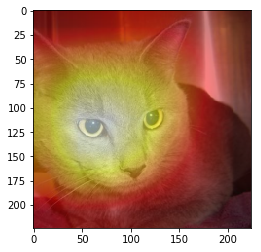

In [295]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');

## Model

In [ ]:
learn.unfreeze()
learn.bn_freeze(True)

In [ ]:
# 12 layer groups call for 12 lrs
lr=np.array([[1e-6]*4,[1e-4]*4,[1e-2]*4]).flatten()

In [ ]:
learn.fit(lr, 2, cycle_len=1)

In [ ]:
log_preds,y = learn.TTA()

In [ ]:
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)

In [ ]:
learn.fit(lr, 2, cycle_len=1)

In [ ]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)
accuracy_np(preds,y)